In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
# import resource

### Load the data:
We first load the data into ghgdata. This cell takes some time, it should be enough to do it once.

In [2]:
N_sites = 2921
N_cols = 327
dghg = 15
Nghg = N_sites * N_cols
ghgdata = np.zeros((dghg+1, Nghg))

pathprefix = "./Data/ghg_data/ghg_data/ghg.gid.site"
for i in range(N_sites):
    filename = pathprefix + str(i + 1).zfill(4) + ".dat"
    subdata = np.genfromtxt(filename, delimiter=" ")
    ghgdata[:,i*N_cols:(i+1)*N_cols] = subdata

ghgdata = ghgdata.T

### Define function to find the smoothness $L$ of the cost function, given a dataset:
We have that for $L$ to guarantee L-smoothness of $f(w)$, it must fulfill the following inequality:
$$ L \succcurlyeq \frac{1}{4N} \sum_i y_i^2 x_i x_i^T + 2\lambda  $$
$$  = \frac{1}{4N} Z^T Z +2\lambda, $$
$$ Z = \begin{bmatrix}y_1 x_1^T \\ \vdots\\ y_N x_N^T\end{bmatrix}.$$

Which is equivalent to $L \geq \frac{1}{4N}\lambda_{\max}(Z^T Z) + 2\lambda $, where $\lambda_{\max}(Z^T Z)$ is the largest eigenvalue of $Z^T Z$.

We implement the finding of the smallest $L$ in the function ``find_smoothness()``.

In [3]:
def find_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as the largest eigenvalue of (1/(4N)) * Z.T @ Z + 2 * lambda.
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    YX = Y * X
    Z = YX.T @ YX
    eigs, _ = np.linalg.eig((1/(4*N))*Z)
    L = np.max(eigs) + 2*lambda_
    
    return L

### Preprocessing of the response variable
We use the first 15 variables of the data as inputs $x_i$, and the 16th row as output.
We found that using the raw output data came with some numerical issues, due to the products $y_i x_i$ being very large quite often.
We therefore threshold the output data into a binary variable in $\{-1,+1\}$.

We here load the ``ghgdata`` into ``X`` and ``Y`` matrices, and perform the thresholding on the ``Y`` matrix.

The plots show histograms of ``Y`` before and after thresholding.

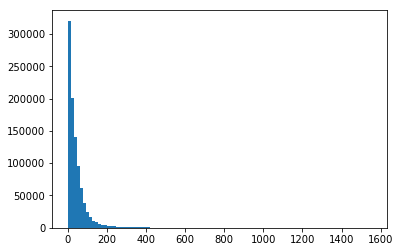

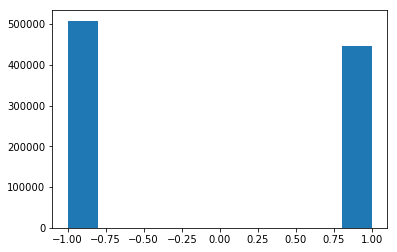

In [4]:
X = ghgdata[:, 0:dghg]
Y = ghgdata[:, [dghg]]
plt.figure(1)
_ = plt.hist(Y, bins=100)

# threshold Y to binary
threshold = 30
mask = Y < threshold
Y[mask] = -1
Y[~mask] = 1
plt.figure(2)
_ = plt.hist(Y)

### Split data into training and testing datasets
We are not really interested in finding a good classifier of the data, but only to verify our implementation of GD, SGD, SVRG and SAG.
Therefore we limit the simulations to only 1000 datapoints for training, to decrease the run time.

In [5]:
# Split train and test data here: (X_train, Y_train, X_test, Y_test)

N_train = math.floor(Nghg*0.75)
N_test = math.floor(Nghg*0.25) + 1

N_train = 1000
N_test = 1000

# train_idx = np.random.choice(Nghg, size=N_train, replace=False)
train_idx = np.arange(N_train)
X_train = X[train_idx, :]
Y_train = Y[train_idx]

# test_idx_bool = ~np.isin(np.arange(Nghg), train_idx)
test_idx = np.arange(N_train, N_train + N_test)
X_test = X[test_idx, :]
Y_test = Y[test_idx]

## Implementing Cost and Gradient functions
#### The logistic ridge regression
$$ f(x) = \frac{1}{N}\sum_{i\in[N]} f_i(x) + \lambda\lVert w \rVert_2^2 $$
has the gradient: 
$$ \nabla f(x) = \frac{1}{N}\sum_{i\in[N]} \nabla f_i(x) + 2\lambda w, $$
$$ \nabla f_i(x) = -y_i x_i \frac{e^{-y_ix_i^T w}}{1 + e^{-y_ix_i^T w}} = -y_i x_i \frac{1}{1 + e^{y_i x_i^T w}}.$$
We use the latter form for computing gradients, since it has better numerical stability (the exponent can take "inf" values, thus the former form is undefined, while the latter is identically zero).

We define the gradient estimate for data point $i$ including regularization as:
$$  \hat{g}_i(w) = \nabla f_i(w) + 2\lambda w.$$

The ``cost()`` function is an implementation of $f(w)$.
The ``function_gradient()`` is an implementation of $\nabla f(w)$, given ``X, Y`` and ``w``.

In [6]:
def cost(x, y, w, lambda_ = 0.01):
    N, d = x.shape
    value = np.sum(np.log(1 + np.exp(- y*x @ w)))
    norm_w = np.linalg.norm(w)
    c = lambda_ * norm_w ** 2
    return value/N + c 

def function_gradient(X, Y, w, lambda_):
    N, d = X.shape
    assert Y.shape == (N,1)
    assert w.shape == (d,1)
    output = np.zeros((N,1))
    YX = Y * X # (N,d)
    YXw = YX @ w # (N,1)
    exp_vec = 1/(1 + np.exp(YXw)) # (N,1)
    grad_array = -YX * exp_vec # (N,d)
    output = np.sum(grad_array, axis=0) # (1,d)
    output = (1/N) * output.reshape(d,1) + 2 * lambda_ * w # (d,1)
    return output # (d,1)

### Implementing the gradient methods

In [7]:
def solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False, return_cost=False, verbose=True):
    if (optimizer == "GD"):
        cost_ = np.zeros(num_iters)
        for i in range(num_iters):
            g = function_gradient(x, y, w, lambda_) # compute the exact gradient wrt w, given x and y
            w = w - alpha * g # GD update
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
            
            if (i%10==0) and (mem):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for GD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                        
            if (np.linalg.norm(g) <= epsilon) and (verbose):
                print("GD: Stop on condition fulfilled! Number of iterations: ", i+1, "/", num_iters)
                break
        if verbose:
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))
                
    elif (optimizer == "SGD"):
        cost_ = np.zeros(num_iters)
        N, d = x.shape
        assert y.shape == (N,1)
        for i in range(num_iters):
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :]
            y_ = y[[i_], :]
            
            g = function_gradient(x_, y_, w, lambda_) # compute gradient
            w = w - alpha * g # GD update 
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
                
    elif (optimizer == "SVRG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        T = 100 # epoch length
        K = math.floor(num_iters/T) # number of epochs, given number of iterations
        
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters
        
        cost_ = np.zeros(T*K)
        
        for k in range(K):
            yx = y * x # (N, d)
            yxw = yx @ w # (N, 1)
            
            assert yx.shape == (N, d)
            assert yxw.shape == (N, 1)
            
            # G_ is equal to using function_gradient, but we need G_vec, so we compute it manually here
            exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
            
            G_vec = (-yx * exp_vec).reshape(d, N) + 2*lambda_*w # (d, N)
                                    
            G_ = (1/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            
            if (np.linalg.norm(G_) <= epsilon) and (verbose): # check the average gradient
                print("SVRG: Stop on condition fulfilled! Number of iterations: ", k*t, "/", num_iters)
                break
            
            assert G_vec.shape == (d, N)
            assert G_.shape == (d, 1)
            
            for t in range(T):
                i_ = int(N*np.random.rand(1))
                x_ = x[[i_], :] # (1, d)
                y_ = y[[i_], :] # (1, 1)
                g = function_gradient(x_, y_, w, lambda_) # (d, 1)
                assert g.shape == (d,1)
                assert G_vec[:, [i_]].shape == (d,1)
                assert G_.shape == (d,1)
                w = w - alpha*(g - G_vec[:, [i_]] + G_)
                
                if return_cost:
                    cost_[t + k*T] = cost(X_test, Y_test, w, lambda_)
                    
        if (K > 0) and (verbose):
            print("SVRG: final norm: ", np.linalg.norm(g))
            
    elif (optimizer == "SAG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        # compute initial gradient estimates for all datapoints
        yx = y * x # (N, d)
        yxw = yx @ w # (N, 1)
        exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
#         G_vec = (-yx * exp_vec).reshape(d, N) + 2 * lambda_ * w # (d, N)
        G_vec = np.zeros((d, N))
        cost_ = np.zeros(num_iters)
        for k in range(num_iters):
            #set_trace()
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :] # (1, d)
            y_ = y[[i_], :] # (1, 1)
            g = function_gradient(x_, y_, w, lambda_) # (d, 1)
            G_vec[:, [i_]] = g # (d, N)
            w = w - (alpha/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            if return_cost:
                cost_[k] = cost(X_test, Y_test, w, lambda_)
                
            if (np.linalg.norm(g) <= epsilon) and (verbose):
                    print("Stop on condition fulfilled! Number of iterations: ", k, "/", num_iters)
                    break
        if verbose:
            print("final norm: ", np.linalg.norm(g))
    if return_cost:
        return w, cost_
    else:
        return w

### Setting the constant stepsize
In these implementations we are using constant stepsize.

We set regularization $\lambda$ and gradient stop condition $\varepsilon$:

In [30]:
## Define solvers: GD, SGD, SVRG and SAG. 
# Setting the values here:

lambda_ = 10 # change the value 1e-6 is good for full matrices
epsilon = 0.000001 # change the value

Load ``Y_train`` and ``X_train`` into ``y`` and ``x``.
Initial guess ``w``:

In [19]:
y = Y_train
x = X_train
print("x: ", x.shape)
print("y: ", y.shape)
N, d = x.shape
w = np.random.rand(d,1)*0.1  # Initialization of w

x:  (1000, 15)
y:  (1000, 1)


In [47]:
# smoothness and convexity
L = find_smoothness(x, y, lambda_)
print("L: ", L)
scaling = 2
alpha = 1/(scaling*L)
alpha_string = "alpha = 1/({0}*L)".format(scaling) + ": "
print(alpha_string, alpha)

L:  5305.216850825762
alpha = 1/(2*L):  9.424685438111254e-05


In [ ]:
#-------------------- GD Solver -----------------------
print(alpha)
num_iters = 10000 # change the value
start = time.time()
gd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False)
end = time.time()
print("Weights of GD after convergence: \n", gd.flatten())
cost_value = cost(X_test, Y_test, gd, lambda_) 
print("Cost of GD after convergence: ", cost_value)

print("Training time for GD: ", end-start)

In [ ]:
#-------------------- SGD Solver -----------------------
num_iters = 10 # change the value
start = time.time()
sgd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "SGD", mem=False)
end = time.time()
print("Weights of SGD after convergence: \n", sgd.flatten())

cost_value = cost(X_test, Y_test, sgd, lambda_)  # Calculate the cost value
print("Cost of SGD after convergence: ", cost_value)

print("Training time for SGD: ", end-start)

In [ ]:
#-------------------- SVRG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
svrg = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SVRG", mem=False)
end = time.time()
print("\nWeights of SVRG after convergence: \n", svrg.flatten())

cost_value = cost(X_test, Y_test, svrg, lambda_)
print("Cost of SVRG after convergence: ", cost_value)
print("Training time for SVRG: ", end-start)

In [ ]:
#-------------------- SAG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
sag = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SAG", mem=False)
end = time.time()
print("Weights of SAG after convergence: \n", sag.flatten())

cost_value = cost(X_test, Y_test, sag, lambda_)
print("Cost of SAG after convergence: ", cost_value)
print("Training time for SAG: ", end-start)

...... 0 .......
GD: Number of iterations:  1 / 1
GD: final norm:  33.14263033428375
SVRG: final norm:  19.358824057280586
final norm:  8.44190636453023
...... 1 .......
GD: Number of iterations:  2 / 2
GD: final norm:  31.531282464277044
SVRG: final norm:  39.250809065284585
final norm:  2.400935710717711
...... 2 .......
GD: Number of iterations:  3 / 3
GD: final norm:  30.032846911148358
SVRG: final norm:  65.08423134448716
final norm:  266.09133935671844
...... 3 .......
GD: Number of iterations:  4 / 4
GD: final norm:  28.64452156429919
SVRG: final norm:  40.20009194853276
final norm:  63.67791623913672
...... 4 .......
GD: Number of iterations:  5 / 5
GD: final norm:  27.361083416406995
SVRG: final norm:  3.621001378162835
final norm:  0.7449453990321123
...... 5 .......
GD: Number of iterations:  6 / 6
GD: final norm:  26.175881452660505
SVRG: final norm:  121.51688951588265
final norm:  2.839309440754329
...... 6 .......
GD: Number of iterations:  7 / 7
GD: final norm:  25.0815

final norm:  22.98602444710687
...... 57 .......
GD: Number of iterations:  58 / 58
GD: final norm:  8.359210449933258
SVRG: final norm:  6.029513039034511
final norm:  29.548230271133253
...... 58 .......
GD: Number of iterations:  59 / 59
GD: final norm:  8.25775451911661
SVRG: final norm:  0.9123198786031416
final norm:  0.6705767798407646
...... 59 .......
GD: Number of iterations:  60 / 60
GD: final norm:  8.158831739270685
SVRG: final norm:  19.910530634197507
final norm:  8.456715458966778
...... 60 .......
GD: Number of iterations:  61 / 61
GD: final norm:  8.062342839613498
SVRG: final norm:  24.33880895437896
final norm:  13.001886560262639
...... 61 .......
GD: Number of iterations:  62 / 62
GD: final norm:  7.968193786885022
SVRG: final norm:  21.80827083716547
final norm:  80.58351119388877
...... 62 .......
GD: Number of iterations:  63 / 63
GD: final norm:  7.876295441873453
SVRG: final norm:  0.7770913217880532
final norm:  130.77119962965912
...... 63 .......
GD: Numbe

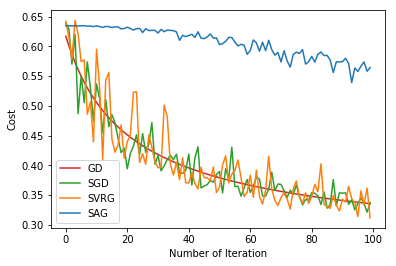

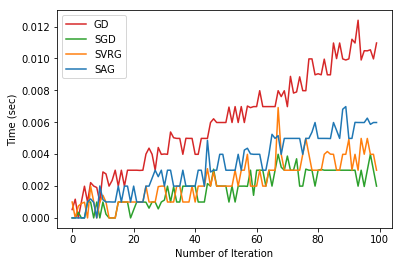

In [15]:
## Executing the iterations and plot the cost function here:
I_max = 100
ti= np.zeros((I_max,4))
cost_= np.zeros((I_max,4))
w = np.random.rand(d,1)*0.01
for i in range(I_max):
    print("......",i,".......")
    #--------------GD-------------------
    start = time.time()
    gd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="GD", mem=False)
    end = time.time()

    cost_[i,0] = cost(X_test, Y_test, gd, lambda_)

    ti[i,0] = end-start

    #---------------SGD------------------
    start = time.time()
    sgd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SGD", mem=False)
    end = time.time()

    cost_[i,1] = cost(X_test, Y_test, sgd, lambda_)

    ti[i,1] = end-start
    
    #---------------SVRG----------------
    start = time.time()
    svrg = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SVRG", mem=False)
    end = time.time()

    cost_[i,2] = cost(X_test, Y_test, svrg, lambda_)

    ti[i,2] = end-start
    
    #---------------SAG------------------
    start = time.time()
    sag = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SAG", mem=False)
    end = time.time()

    cost_[i,3] = cost(X_test, Y_test, sag, lambda_)

    ti[i,3] = end-start
    
    #------------------------------------
    
    ## Pl the results:
    

l0 = plt.plot(cost_[:,0],color="C3")
l1 = plt.plot(cost_[:,1],color="C2")
l2 = plt.plot(cost_[:,2],color="C1")
l3 = plt.plot(cost_[:,3],color="C0")
# complete other plots here: 


plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

l0 = plt.plot(ti[:,0],color="C3")
l1 = plt.plot(ti[:,1],color="C2")
l2 = plt.plot(ti[:,2],color="C1")
l3 = plt.plot(ti[:,3],color="C0")
# complete other plots here:

plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

alpha = 1/(2*L):  9.424685438111254e-05
...... 1 .......
...... 2 .......
...... 3 .......
...... 4 .......
...... 5 .......
...... 6 .......
...... 7 .......
...... 8 .......
...... 9 .......
...... 10 .......


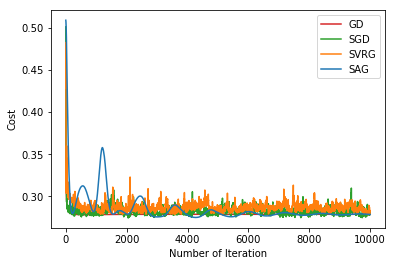

In [55]:
## Executing the iterations and plot the cost function here:
print(alpha_string, alpha)
n_sims = 10
I_max = 10000
ti= np.zeros((I_max,4))
cost_= np.zeros((I_max,4))
for n in range(n_sims):
    w = np.random.rand(d,1)*0.01
    
    print("......",n+1,".......")
    #--------------GD-------------------
    gd, gd_cost  = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="GD", mem=False, return_cost=True, verbose=False)

    cost_[:,0] += gd_cost/n_sims

    #---------------SGD------------------
    sgd, sgd_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SGD", mem=False, return_cost=True, verbose=False)

    cost_[:,1] += sgd_cost/n_sims
    
    #---------------SVRG----------------
    svrg, svrg_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SVRG", mem=False, return_cost=True, verbose=False)

    cost_[:,2] += svrg_cost/n_sims
    
    #---------------SAG------------------
    sag, sag_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SAG", mem=False, return_cost=True, verbose=False)
    
    cost_[:,3] += sag_cost/n_sims
    
    #------------------------------------
## PLOTs
l0 = plt.plot(cost_[:,0],color="C3")
l1 = plt.plot(cost_[:,1],color="C2")
l2 = plt.plot(cost_[:,2],color="C1")
l3 = plt.plot(cost_[:,3],color="C0")
# complete other plots here: 

plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])
plt.show()

(15000, 20000)

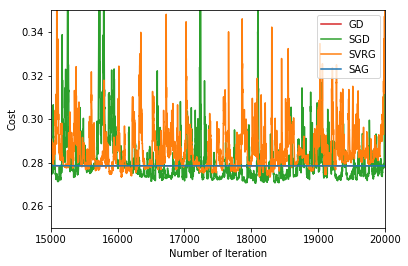

In [54]:
## PLOTs
l0 = plt.plot(cost_[:,0],color="C3")
l1 = plt.plot(cost_[:,1],color="C2")
l2 = plt.plot(cost_[:,2],color="C1")
l3 = plt.plot(cost_[:,3],color="C0")
# complete other plots here: 

plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend(['GD', 'SGD', 'SVRG', 'SAG'])

plt.ylim(0.25, .35)
plt.xlim(15000,20000)

In [ ]:
## Tunning the hyper-paramter here:

In [ ]:
## Comparing different optimizers here: 